# 라이브러리 로드 및 데이터 로드

In [70]:
# 맞춤법 검사 라이브러리 py-hanspell
# # !pip install git+https://github.com/ssut/py-hanspell.git

In [134]:
# 라이브러리 로드
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 전처리
import re
from hanspell import spell_checker
from tqdm import tqdm
from konlpy.tag import Okt
from collections import Counter

# 바이너리 파일 저장 및 로드
import pickle

In [72]:
# 데이터셋 로드
# root_dir = "data"

# df = pd.read_parquet(f"{root_dir}/all_append_csv_12_26_1200i.gzip")
# display(df.head())
# df.shape

In [73]:
# 발라드만 떼오기
# df_ballad = df[df["장르"] == "발라드"].copy()
# df_ballad.shape

In [74]:
root_dir = "data"
df_ballad = pd.read_csv(f"{root_dir}/melon_ballad_1_15000.csv", parse_dates=["발매일"])
display(df_ballad.head())
df_ballad.shape

,제목,가사,가수,발매일,좋아요수,장르
0,Monologue,다 잊었다는 거짓말\n또 해 버렸죠\n내 마음에 그대란 사람\n없다고 했죠\n너무나...,테이,2022.09.18,"66,062",발라드
1,너의 모든 순간,이윽고 내가 한눈에\n너를 알아봤을 때\n모든 건 분명 달라지고 있었어\n내 세상은...,성시경,2014.02.12,"243,092","발라드, 국내드라마"
2,잘가요,미안해 마요 이제야 난 깨달아요\n내 절대 그대 짝이 아님을\n괜찮을게요 영혼 밖에...,주호,2022.12.04,"18,702",발라드
3,사랑은 늘 도망가,눈물이 난다 이 길을 걸으면\n그 사람 손길이 자꾸 생각이 난다\n붙잡지 못하고 가...,임영웅,2021.10.11,"185,585","발라드, 국내드라마"
4,해요 (2022),그녀와 나는요 그땐 참 어렸어요\n많이 사랑했고 때론 많이 다퉜었죠\n지금 생각하면...,#안녕,2022.06.07,"63,808","발라드, 인디음악"


(13346, 6)

# 컬럼 전처리

## 데이터 타입 변경

In [75]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13346 entries, 0 to 13345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      13346 non-null  object
 1   가사      13346 non-null  object
 2   가수      13346 non-null  object
 3   발매일     13346 non-null  object
 4   좋아요수    13346 non-null  object
 5   장르      13346 non-null  object
dtypes: object(6)
memory usage: 625.7+ KB


In [76]:
# 발매일 없는 데이터는 na로 처리
df_ballad["발매일"] = pd.to_datetime(df_ballad["발매일"], errors="coerce")

# 발매일 없는 데이터는 채울까 ? drop 할까?
df_ballad = df_ballad.dropna(subset=["발매일"])

In [77]:
# 좋아요 수 int 타입으로 변경
df_ballad["좋아요수"] = df_ballad["좋아요수"].str.replace(",", "")
df_ballad["좋아요수"] = df_ballad["좋아요수"].astype(int)

In [78]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13340 entries, 0 to 13345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      13340 non-null  object        
 1   가사      13340 non-null  object        
 2   가수      13340 non-null  object        
 3   발매일     13340 non-null  datetime64[ns]
 4   좋아요수    13340 non-null  int32         
 5   장르      13340 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 677.4+ KB


## 장르 구분

In [79]:
# 장르 구분
genre_split = df_ballad["장르"].str.split(",")
df_ballad["장르1"] = genre_split.str.get(0)
df_ballad["장르2"] = genre_split.str.get(1)
df_ballad["장르3"] = genre_split.str.get(2)
df_ballad["장르4"] = genre_split.str.get(3)

In [80]:
# 장르 분포 확인
# 장르는 한 곡에 최대 4개까지 있으나 양이 적어서 필요한 컬럼만 사용
display(df_ballad["장르1"].value_counts())
print("-"*30)
display(df_ballad["장르2"].value_counts())
print("-"*30)
display(df_ballad["장르3"].value_counts())
print("-"*30)
display(df_ballad["장르4"].value_counts())

발라드    13340
Name: 장르1, dtype: int64

------------------------------


 국내드라마       2381
 인디음악        1165
 국내영화          85
 애니메이션/웹툰      81
 R&B/Soul      71
 랩/힙합          41
 록/메탈          33
 게임            16
 포크/블루스        10
 성인가요/트로트       8
 댄스             5
 국외영화           5
Name: 장르2, dtype: int64

------------------------------


 국내드라마       68
 포크/블루스       4
 키즈           3
 랩/힙합         1
 애니메이션/웹툰     1
 국내영화         1
Name: 장르3, dtype: int64

------------------------------


 만화    3
Name: 장르4, dtype: int64

## 날짜, 요일 추가
* 일단 다각면에서 분석하고자 다 만들어두긴 했으나.. 연도와 월 빼고는 쓸모가 없을 듯 싶다

In [81]:
# 날짜, 요일 추가
df_ballad["년"] = df_ballad["발매일"].dt.year
df_ballad["월"] = df_ballad["발매일"].dt.month
# df_ballad["일"] = df_ballad["발매일"].dt.day
# df_ballad["요일"] = df_ballad["발매일"].dt.dayofweek

In [108]:
# 계절 추가
df_ballad.loc[df_ballad["월"].isin([12,1,2]), "계절"] = "겨울"
df_ballad.loc[df_ballad["월"].isin([3,4,5]), "계절"] = "봄"
df_ballad.loc[df_ballad["월"].isin([6,7,8]), "계절"] = "여름"
df_ballad.loc[df_ballad["월"].isin([9,10,11]), "계절"] = "가을"

In [ ]:
# 계절별 노래 개수
df_ballad["계절"].value_counts()

In [83]:
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13340 entries, 0 to 13345
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      13340 non-null  object        
 1   가사      13340 non-null  object        
 2   가수      13340 non-null  object        
 3   발매일     13340 non-null  datetime64[ns]
 4   좋아요수    13340 non-null  int32         
 5   장르      13340 non-null  object        
 6   장르1     13340 non-null  object        
 7   장르2     3901 non-null   object        
 8   장르3     78 non-null     object        
 9   장르4     3 non-null      object        
 10  년       13340 non-null  int64         
 11  월       13340 non-null  int64         
 12  계절      13340 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(9)
memory usage: 1.4+ MB


# EDA

## 중복행 제거

In [84]:
# 중복행 한 번 더 확인
df_ballad[df_ballad.duplicated(keep=False)]

,제목,가사,가수,발매일,좋아요수,장르,장르1,장르2,장르3,장르4,년,월,계절
6531,Goodbye To Romance(민서 X 김이나 프로젝트) (Inst.),It's time for goodbye\n나의 로맨스여 Goodbye\n바로 어제처...,민서 (MINSEO),2022-12-26,11,발라드,발라드,NaN,NaN,NaN,2022,12,겨울
7889,욕심,너무 늦어버린걸 이미 알고 있어 난\n괜히 또 괜찮은 척 웃고있어\n바쁜 하루 중에...,성민,2022-08-30,85,발라드,발라드,NaN,NaN,NaN,2022,8,여름
7970,소낙눈,보석처럼 빛나는 아침\n단비 같은 눈이 내렸어\n눈부시던 창 밖 풍경에\n괜시리 맘...,소낙별,2017-01-24,225,발라드,발라드,NaN,NaN,NaN,2017,1,겨울
8028,기억을 걷다,참 많이도 웃었지\n숨 쉬듯 내 곁에 있었지\n편안했었고 친절했었지\n그때 너는 그...,정승환,2015-04-05,7550,발라드,발라드,NaN,NaN,NaN,2015,4,봄
8151,백허그 (Back Hug),백허그 (Back Hug)\n\n가만히 뒤에서 날 끌어안아줘\n내 어깨에 턱을 기대...,소녀시대 (GIRLS' GENERATION),2014-02-24,8623,발라드,발라드,NaN,NaN,NaN,2014,2,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11211,견뎌야 하는 우리에게,문득 생각을 해봤어\n지난날 우린 누구보다\n뜨겁고 미친 듯이 사랑했고\n아껴줬잖아...,먼데이 키즈 (Monday Kiz),2020-05-20,3000,발라드,발라드,NaN,NaN,NaN,2020,5,봄
11220,우리들의 겨울이야기 (feat.뮤시아),나 오랫동안 준비해 왔던\n그 말을 전할 때가 온 거야\n그대가 좋아하는 하얀 겨울...,EQ,2022-12-21,27,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,12,겨울
11515,Hate Christmas,우 모두 기다렸던\n메리 크리스마스\n홀로 쓸쓸한 이 밤\n설레는 예쁜 연인들\n그...,임도혁,2016-12-21,450,발라드,발라드,NaN,NaN,NaN,2016,12,겨울
11532,후회 (Original ver.),아무렇지 않은 척했네\n그대 떠난 자리에 서서\n슬퍼하지 않으려 했네\n내 슬픔이 ...,범진,2022-02-28,271,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,2,겨울


In [85]:
# 중복행 drop
print(df_ballad.shape)
df_ballad = df_ballad.drop_duplicates()
df_ballad.shape

(13340, 13)


(13124, 13)

## 시각화

In [86]:
# 필요 없는 단어 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("1절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("2절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("브리지", "", x).strip())

In [87]:
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", "", x)) # 공백 2회 이상 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\n", " ", x)) # 개행문자 제거

In [88]:
df_ballad

,제목,가사,가수,발매일,좋아요수,장르,장르1,장르2,장르3,장르4,년,월,계절
0,Monologue,다 잊었다는 거짓말 또 해 버렸죠 내 마음에 그대란 사람 없다고 했죠 너무나 쉽게 ...,테이,2022-09-18,66062,발라드,발라드,NaN,NaN,NaN,2022,9,겨울
1,너의 모든 순간,이윽고 내가 한눈에 너를 알아봤을 때 모든 건 분명 달라지고 있었어 내 세상은 널 ...,성시경,2014-02-12,243092,"발라드, 국내드라마",발라드,국내드라마,NaN,NaN,2014,2,겨울
2,잘가요,미안해 마요 이제야 난 깨달아요 내 절대 그대 짝이 아님을 괜찮을게요 영혼 밖에 팔...,주호,2022-12-04,18702,발라드,발라드,NaN,NaN,NaN,2022,12,겨울
3,사랑은 늘 도망가,눈물이 난다 이 길을 걸으면 그 사람 손길이 자꾸 생각이 난다 붙잡지 못하고 가슴만...,임영웅,2021-10-11,185585,"발라드, 국내드라마",발라드,국내드라마,NaN,NaN,2021,10,겨울
4,해요 (2022),그녀와 나는요 그땐 참 어렸어요 많이 사랑했고 때론 많이 다퉜었죠 지금 생각하면 모...,#안녕,2022-06-07,63808,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,6,여름
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13341,긴 밤을 나 혼자 보내기엔,나는 알지 못했죠 그대 내게 얼마나 소중했었는지 이제 알 것 같아요 그땐 내가 얼마...,최도영(CANDO),2022-06-26,154,"발라드, 국내드라마",발라드,국내드라마,NaN,NaN,2022,6,여름
13342,Rooting for you,오 기억하나요 설레였나요 그 여름 함께였던 우리를 그시간 속에서 사계절의 우리를 (...,DIA (다이아),2022-09-14,641,발라드,발라드,NaN,NaN,NaN,2022,9,겨울
13343,지금 청혼하는 거야,지금 네게 청혼을 하는 거야 미친 듯이 뛰는 심장을 부여잡고 날씨마저 화창한 오늘 ...,이성혁,2022-10-08,64,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,10,겨울
13344,My First Love (나와 결혼해 줄래요) (inst.),그대 눈을 바라볼 때면 느낄 수 있죠 떨리는 맘 um 말하지 않아도 내 맘이 그댈 ...,허각,2022-10-16,797,발라드,발라드,NaN,NaN,NaN,2022,10,겨울


### 가수별 분석

In [89]:
# 가수별 곡 수
df_singer_soundtrack = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("제목", ascending=False).reset_index()

# 가수별 좋아요 수
df_singer_like = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("좋아요수", ascending=False).reset_index()
display(df_singer_soundtrack.head())
df_singer_like.head()

,가수,제목,좋아요수
0,먼데이 키즈 (Monday Kiz),130,1250007
1,성시경,129,2461336
2,엠씨더맥스 (M.C the MAX),127,2298255
3,지아,109,802739
4,임창정,109,1733212


,가수,제목,좋아요수
0,아이유,75,5405204
1,태연 (TAEYEON),54,2633545
2,박효신,90,2484356
3,성시경,129,2461336
4,엠씨더맥스 (M.C the MAX),127,2298255


<AxesSubplot: xlabel='제목', ylabel='가수'>

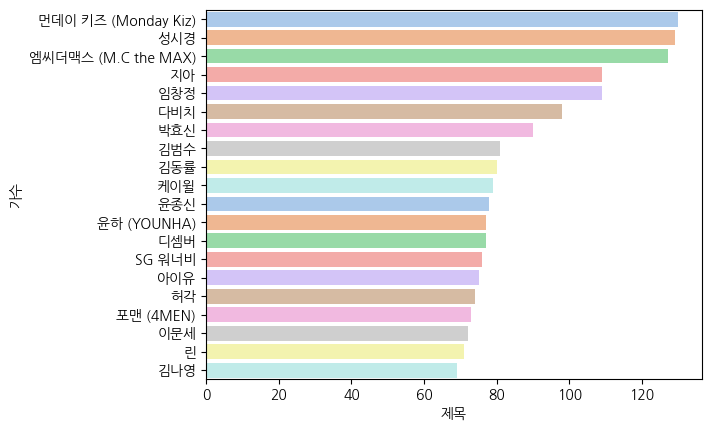

In [99]:
# 곡 수 top 20 시각화
sns.barplot(df_singer_soundtrack[:20], x="제목", y="가수", palette = sns.color_palette("pastel"))

<AxesSubplot: xlabel='좋아요수', ylabel='가수'>

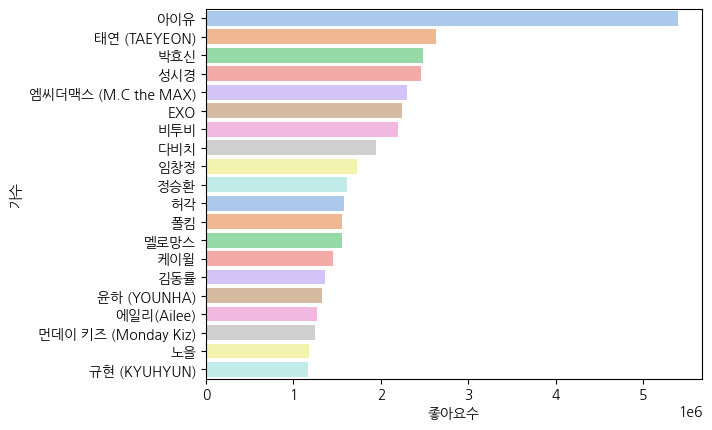

In [100]:
# 좋아요 수 top 20 시각화
sns.barplot(df_singer_like[:20], x="좋아요수", y="가수", palette = sns.color_palette("pastel"))

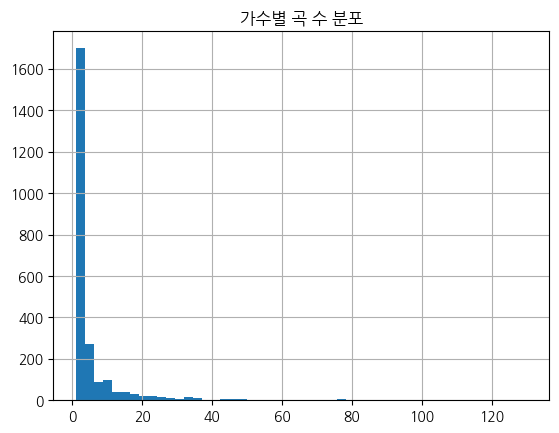

In [92]:
# 가수별 곡 수의 분포
df_singer_soundtrack["제목"].hist(bins=50).set_title("가수별 곡 수 분포");

- 인기순에 노래가 많이 오른 가수들의 노래는 대중들로부터 인정을 받았다고 볼 수 있기 때문에 이 곡들의 가사로 학습해봐도 괜찮지 않을까?
- 혹은 음악의 좋아요 수가 많은 가수들의 노래?
- 이 두 가지를 혼합한 기준?

### 연도별 분석

<AxesSubplot: xlabel='년', ylabel='제목'>

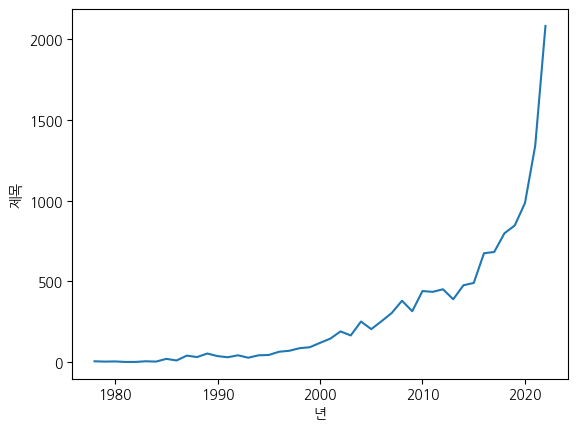

In [102]:
# 연도별 인기순 데이터
sns.lineplot(data=df_ballad.groupby("년")[["제목"]].count().reset_index(), x="년", y="제목")

- 발라드 장르 "최신곡"의 인기순 정렬이다보니 최신으로 갈수록 데이터가 많아짐(1~15000곡 기준)

### 곡별 가사 길이 분포

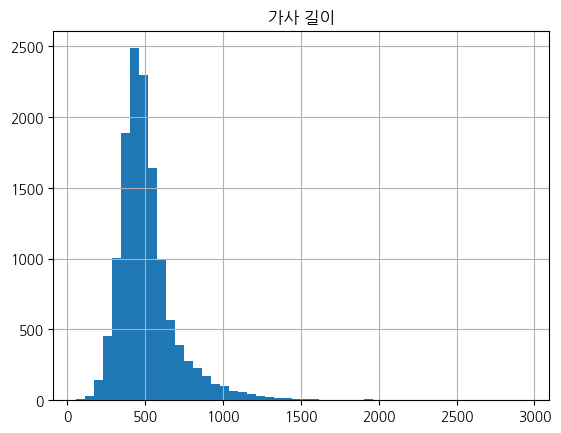

In [94]:
# 가사 길이 분포
df_ballad["가사"].str.len().hist(bins=50).set_title("가사 길이");

- 공백 포함 약 300~600자 사이에 가장 많이 분포함
- 가사 전처리를 러프하게 했기 때문에 실제 가사 길이와 오차는 있을 수 있음(특수문자 등)

## 맞춤법 검사기 활용
- 네이버 맞춤법 검사기 기반의 `py-hanspell` 라이브러리 사용
- 네이버 맞춤법 검사기 기반이기 때문에 500자가 넘어가면 사용하지 못하므로 문장 단위로 끊어서 사용해야함
- 사용하게 된다면 모델에 input할 가사만 맞춤법 검사해도 될듯
- 형태소 분석기 사용 시 띄어쓰기 처리 알아서 끊어주기 때문에 사용 x

In [95]:
# spell_checker()

## 형태소 분석

In [96]:
# 형태소 분석기 호출 및 함수 정의
okt = Okt()
def okt_clean(text):
    clean_text = []
    # 품사 태깅 후 태깅 결과를 받아서 순회 
    for word in okt.pos(text, norm=True, stem=True):
        # 품사가 조사, 어미, 구두점이면 제외하고 append 로 인덱스 0번 값만 다시 리스트에 담아줌
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean_text.append(word[0])
    # 공백 문자로 연결
    return " ".join(clean_text)

In [97]:
# 판다스에서 tqdm 기능 사용하기 위해 선언
tqdm.pandas()

In [98]:
# 약 10분 소요
df_ballad["가사_전처리"] = df_ballad["가사"].progress_map(okt_clean)

100%|████████████████████████████████████████████████████████████████████████████| 13124/13124 [10:14<00:00, 21.34it/s]


### 계절별 분석
- 사랑에 미쳐버린 노래들..
- 계절별로 노래 가사 단어 빈도의 뚜렷한 차이는 발견하지 못했음

In [121]:
# 각 계절별 좋아요수 상위 20개 추출
df_ballad_spring = df_ballad[df_ballad["계절"] == "봄"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_summer = df_ballad[df_ballad["계절"] == "여름"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_fall = df_ballad[df_ballad["계절"] == "가을"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_winter = df_ballad[df_ballad["계절"] == "겨울"].sort_values("좋아요수", ascending=False).head(50)

In [129]:
# 하나의 문자열로 추출
lyrics_spring = ' '.join(df_ballad_spring["가사"])
lyrics_summer = ' '.join(df_ballad_summer["가사"])
lyrics_fall = ' '.join(df_ballad_fall["가사"])
lyrics_winter = ' '.join(df_ballad_winter["가사"])

In [193]:
# 봄 빈도수 상위 30개 명사 추출(너, 나, 내 같이 의미없는 한 자 단어가 많아서 한글자는 제외함)
lyrics_spring_noun = okt.nouns(lyrics_spring)
count_spring = Counter(lyrics_spring_noun)
count_spring_dict = dict(count_spring.most_common(100))
count_spring_df = pd.DataFrame(count_spring_dict.values(), count_spring_dict.keys())
count_spring_df = count_spring_df.reset_index()
count_spring_df.columns = ["단어", "빈도"]
count_spring_df = count_spring_df[count_spring_df["단어"].str.len() != 1].head(30)

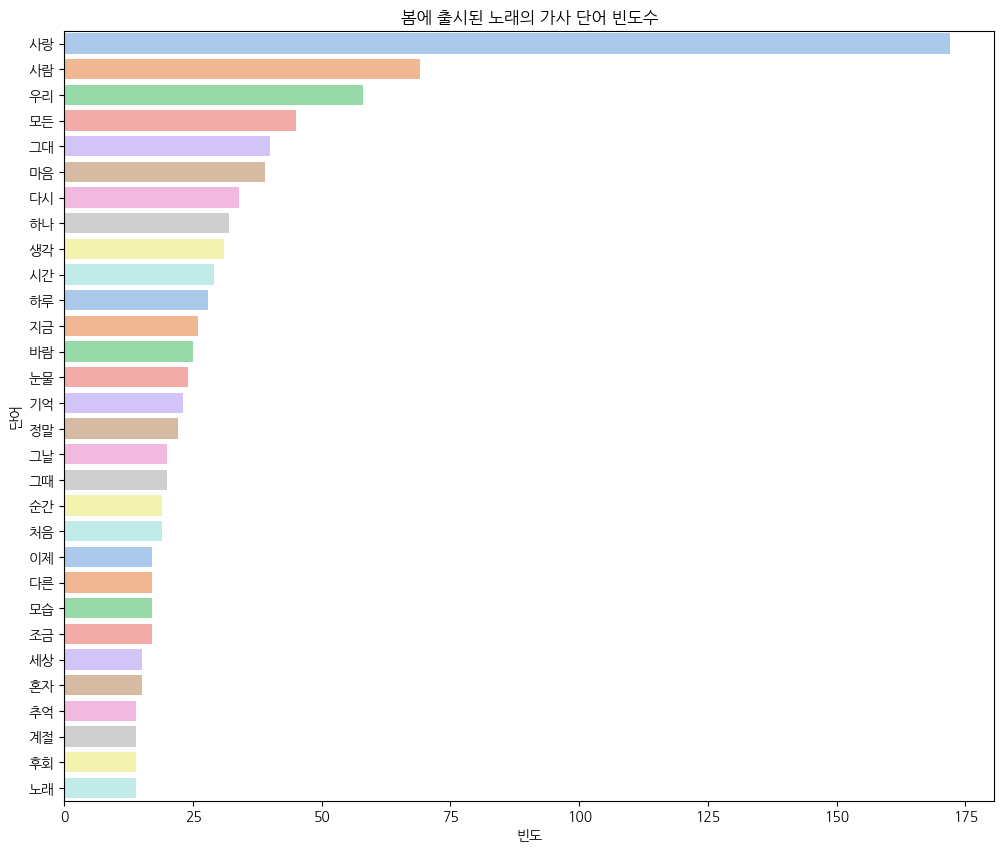

In [202]:
# 봄 시각화
plt.figure(figsize=(12,10))
plt.title("봄에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_spring_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [195]:
lyrics_summer_noun = okt.nouns(lyrics_summer)
count_summer = Counter(lyrics_summer_noun)
count_summer_dict = dict(count_summer.most_common(100))
count_summer_df = pd.DataFrame(count_summer_dict.values(), count_summer_dict.keys())
count_summer_df = count_summer_df.reset_index()
count_summer_df.columns = ["단어", "빈도"]
count_summer_df = count_summer_df[count_summer_df["단어"].str.len() != 1].head(30)

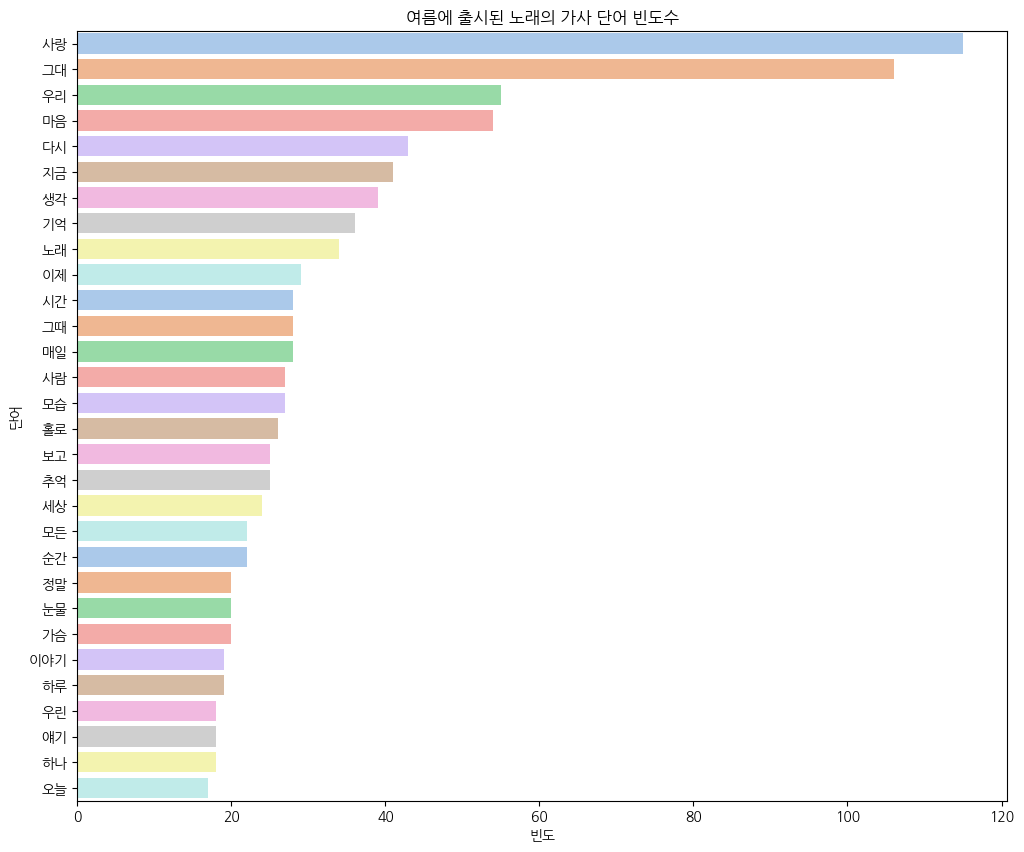

In [203]:
# 여름 시각화
plt.figure(figsize=(12,10))
plt.title("여름에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_summer_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [197]:
lyrics_fall_noun = okt.nouns(lyrics_fall)
count_fall = Counter(lyrics_fall_noun)
count_fall_dict = dict(count_fall.most_common(100))
count_fall_df = pd.DataFrame(count_fall_dict.values(), count_fall_dict.keys())
count_fall_df = count_fall_df.reset_index()
count_fall_df.columns = ["단어", "빈도"]
count_fall_df = count_fall_df[count_fall_df["단어"].str.len() != 1].head(30)

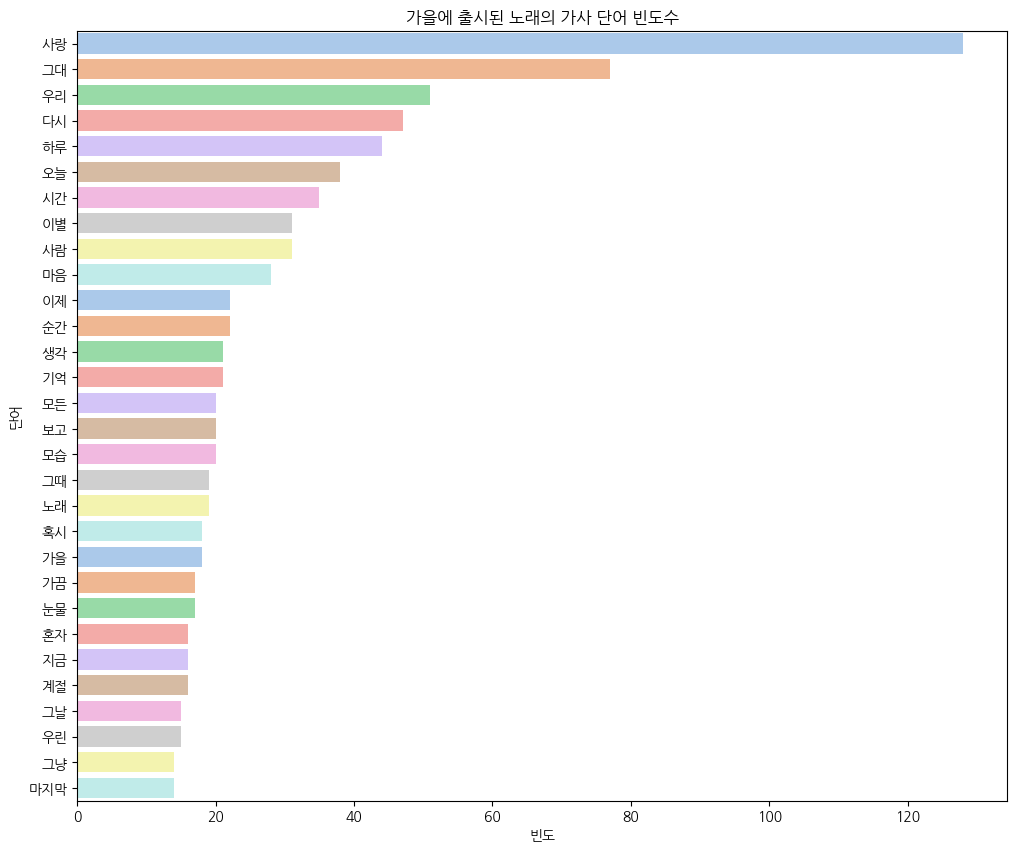

In [204]:
# 가을 시각화
plt.figure(figsize=(12,10))
plt.title("가을에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [199]:
lyrics_winter_noun = okt.nouns(lyrics_winter)
count_winter = Counter(lyrics_winter_noun)
count_winter_dict = dict(count_winter.most_common(100))
count_winter_df = pd.DataFrame(count_winter_dict.values(), count_winter_dict.keys())
count_winter_df = count_winter_df.reset_index()
count_winter_df.columns = ["단어", "빈도"]
count_winter_df = count_winter_df[count_winter_df["단어"].str.len() != 1].head(30)

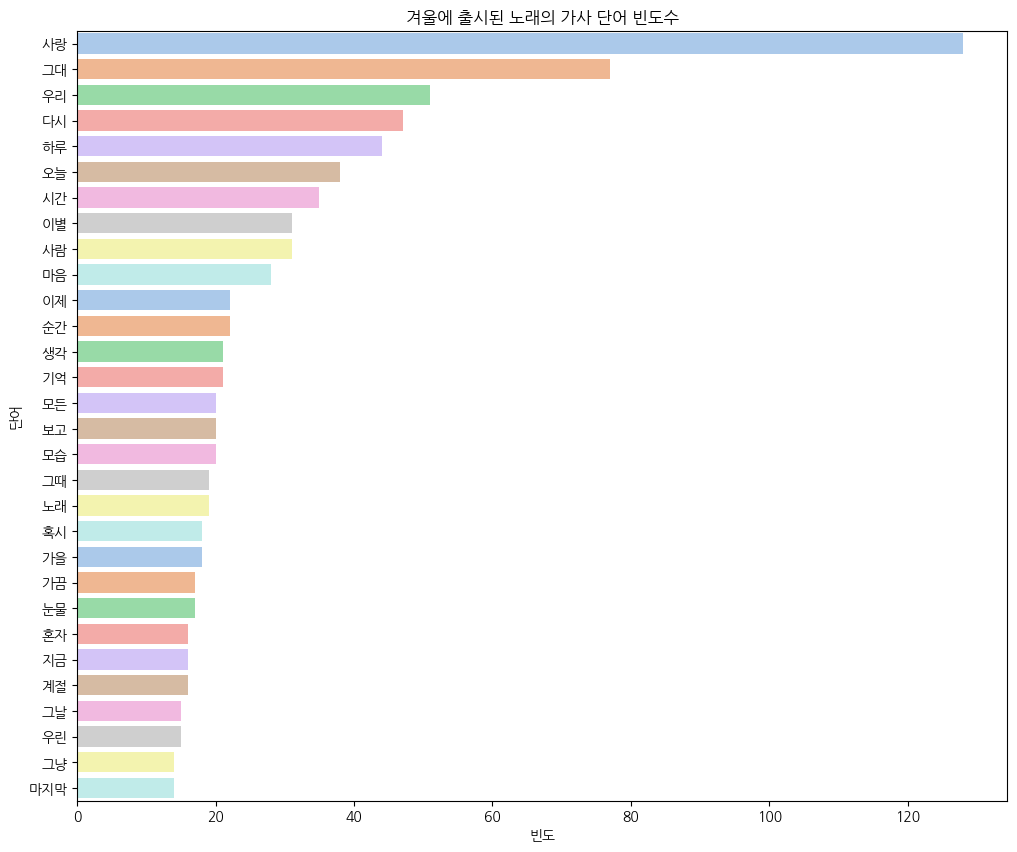

In [205]:
# 겨울 시각화
plt.figure(figsize=(12,10))
plt.title("겨울에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

# 모델 input을 위한 전처리

In [25]:
# 가사에 개행문자 없는 데이터 제거
# df_ballad = df_ballad[df_ballad["가사"].str.contains("\n")]

In [26]:
# 기본 전처리
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("[^ㄱ-ㅎ가-힣0-9\n ]", "", x).strip()) # 한글 자음, 한글, 숫자, 개행문자만 남기고 제거
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", "", x)) # 공백 2회 이상 제거
# df_ballad = df_ballad[df_ballad["가사"].map(lambda x : len(x) > 10)] # 전처리 후 빈 행이나 10자 이상이 안되는 데이터 제거
# df_ballad = df_ballad.reset_index(drop=True) # 인덱스 초기화
# df_ballad.shape